In [1]:
import os
import cv2
import torch
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.io import read_image
from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision.models import inception_v3, Inception_V3_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
!ls /kaggle/input

H1  H2	H3  H5	H6


In [4]:
label_dict = {'H1':'TSH', 'H2':'BASH', 'H3':'GMA', 'H5':'SHC', 'H6':'BBH'}
PATH = r'/kaggle/input'
paths = []
img_labels = []
for filenames in os.listdir(PATH):
    for file in os.listdir(os.path.join(PATH,filenames)):
        paths.append(os.path.join(PATH,filenames,file))
        img_labels.append(label_dict[filenames])

In [5]:
df = pd.DataFrame({'File':paths,'Label':img_labels})

In [6]:
encode = {'BASH':0, 'BBH':1, 'GMA':2, 'SHC':3, 'TSH':4}
labels = np.array(list(map(lambda x : encode[x], img_labels)))
# labels = np.array(img_labels)

In [7]:
labels.shape

(9114,)

In [8]:
df.head()

,File,Label
0,/kaggle/input/H3/H3_5a_17.jpg,GMA
1,/kaggle/input/H3/H3_5b_9.jpg,GMA
2,/kaggle/input/H3/H3_11a_42.jpg,GMA
3,/kaggle/input/H3/H3_3c_16.jpg,GMA
4,/kaggle/input/H3/H3_36a_1.jpg,GMA


In [9]:
df.shape

(9114, 2)

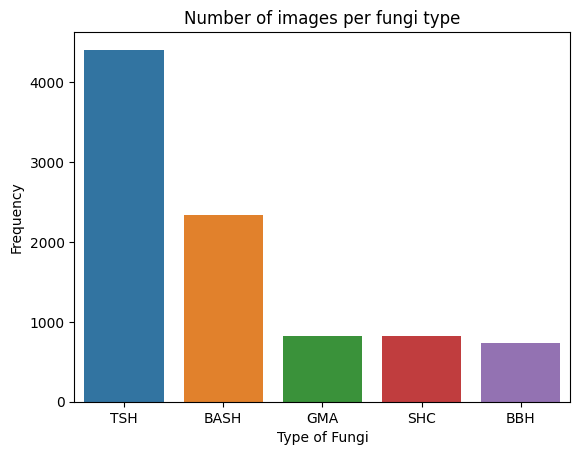

In [10]:
_ = df['Label'].value_counts()
sns.barplot(x=_.index, y=_.values)
plt.title("Number of images per fungi type")
plt.xlabel("Type of Fungi")
plt.ylabel("Frequency")
plt.show()

**This shows that the dataset is imbalanced**

In [11]:
df = pd.get_dummies(df, columns=['Label'], dtype=float, prefix='', prefix_sep='')

In [12]:
df.head()

,File,BASH,BBH,GMA,SHC,TSH
0,/kaggle/input/H3/H3_5a_17.jpg,0.0,0.0,1.0,0.0,0.0
1,/kaggle/input/H3/H3_5b_9.jpg,0.0,0.0,1.0,0.0,0.0
2,/kaggle/input/H3/H3_11a_42.jpg,0.0,0.0,1.0,0.0,0.0
3,/kaggle/input/H3/H3_3c_16.jpg,0.0,0.0,1.0,0.0,0.0
4,/kaggle/input/H3/H3_36a_1.jpg,0.0,0.0,1.0,0.0,0.0


In [13]:
class FungiDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        image = np.array(Image.open(img_path), dtype=float)#.transpose(1,2,0)
        label = torch.tensor(self.df.iloc[idx, 1:],dtype=torch.float64)
        if self.transform:
            aug = self.transform(image=image)
            image = aug['image']
        return {'image': image, 'labels': label}

In [14]:
a = FungiDataset(df)
a[0]['image'].shape

(500, 500, 3)

In [ ]:
img = cv2.imread(df.iloc[0, 0])
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title
plt.show()

In [16]:
import albumentations as A
from albumentations import Compose, CenterCrop, HorizontalFlip, Normalize, RandomRotate90, RandomBrightnessContrast, Resize
from albumentations.pytorch import ToTensorV2

transform_train = Compose([ 
                    Resize(342,342,interpolation=cv2.INTER_LINEAR),
                    CenterCrop(299,299),
                    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    A.OneOf([
                        RandomRotate90(p=0.3),
                        HorizontalFlip(p=0.3),
                    ]),
                    RandomBrightnessContrast(p=0.3),
                    ToTensorV2()
])

transform_test= Compose([
                    Resize(342,342,interpolation=cv2.INTER_LINEAR),
                    CenterCrop(299,299),
                    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
])

In [17]:
skf = StratifiedKFold(n_splits=10)


#Inside the loop, do the following:
#Make Dataset according to indices
#Make Dataloader
#Train the model
#NOTE : The array 'labels' is only used so that stratification while splitting can occur
CLASSES = 5
x = 1
train_hist = {}
val_hist = {}
for train_index, test_index in skf.split(df, labels):
    #Validation Split
    X_train, X_val, y_train, y_val = train_test_split(df.iloc[train_index],labels[train_index],stratify=labels[train_index],test_size=0.15,random_state=42)
    
    #Creating datasets
    train_dataset = FungiDataset(df.iloc[train_index], transform=transform_train)
#     val_dataset = FungiDataset(X_val, transform=transform_test)
    test_dataset = FungiDataset(df.iloc[test_index], transform=transform_test)
    
    #Creating data Loaders
    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=26, shuffle=True, num_workers=4)
#     data_loader_val = torch.utils.data.DataLoader(train_dataset, batch_size=70, shuffle=False, num_workers=4)
    data_loader_val = torch.utils.data.DataLoader(test_dataset, batch_size=70, shuffle=False, num_workers=4)
    
    #Setting model, set loss fn, set optimizer
    inception= inception_v3(weights='DEFAULT')
    inception.fc= nn.Linear(in_features=2048, out_features=CLASSES, bias=True)
    model= inception
#     print(model)
    model.to(device)
    criterion= nn.BCEWithLogitsLoss()
    optimizer= optim.Adam(model.parameters(),lr=2e-5)
    
    #variables to be used in epochs
    n_epochs = 80
    history_train = {'accuracy': [], 'loss': [] , 'precision': [], 'f1': []}
    history_val = {'accuracy': [] , 'precision': [], 'f1': []}
#     history_test = {'accuracy': [] , 'precision': [], 'f1': []}
    
    print("-"*10,f"Split : {x}","-"*10)
    
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch, n_epochs - 1))
        print('-' * 10)

        model.train()
        tr_loss = 0
        y_true_train, y_pred_train = [], []

        total_batches = len(data_loader_train)
        tk0 = tqdm(data_loader_train, total=total_batches, desc="Iteration", position=0, leave=True)

        for step, batch in enumerate(tk0):
            inputs = batch["image"]
            b_labels = batch["labels"]

            inputs = inputs.to(device, dtype=torch.float)
            b_labels = b_labels.to(device, dtype=torch.float)
            
            outputs = model(inputs).logits
#             print(outputs)
#             print(type(outputs))
            loss = criterion(outputs, b_labels)

            loss.backward()

            tr_loss += loss.item()

            optimizer.step()
            optimizer.zero_grad()

            # Collect true and predicted labels for metrics calculation
            y_true_train.extend(b_labels.cpu().numpy())
            y_pred_train.extend(outputs.cpu().detach().numpy())
        
        #Calculate accuracy wrt Training data
        y_true_train = np.argmax(y_true_train, axis=1)
        y_pred_train = np.argmax(y_pred_train,axis=1)
        
        #Calculate accuracy wrt validation dataset
        model.eval()
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for batch in data_loader_val:
                inputs = batch['image'].to(device, dtype=torch.float)
                b_labels = batch['labels']
                outputs = model(inputs)
                y_pred_val.extend(outputs.cpu().detach().numpy())
                y_true_val.extend(b_labels.cpu().numpy())
            
            y_true_val = np.argmax(y_true_val, axis=1)
            y_pred_val = np.argmax(y_pred_val,axis=1)
                
         
        accuracy_train = accuracy_score(y_true_train, y_pred_train)
        precision_train = precision_score(y_true_train, y_pred_train, average='weighted')
        f1_train = f1_score(y_true_train, y_pred_train, average='weighted')
        
        accuracy_val = accuracy_score(y_true_val, y_pred_val)
        precision_val = precision_score(y_true_val, y_pred_val, average='weighted')
        f1_val = f1_score(y_true_val, y_pred_val, average='weighted')
            
        # Calculate training loss for the epoch
        epoch_loss = tr_loss / len(data_loader_train)
        print('Training Loss: {:.4f}'.format(epoch_loss))
        print('Training Accuracy: {:.4f}'.format(accuracy_train))
        print('Validation Accuracy: {:.4f}'.format(accuracy_val))
        
        history_train['loss'].append(epoch_loss)
        history_train['accuracy'].append(accuracy_train)
        history_train['precision'].append(precision_train)
        history_train['f1'].append(f1_train)
        
        history_val['accuracy'].append(accuracy_val)
        history_train['precision'].append(precision_val)
        history_train['f1'].append(f1_val)
        
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f'inception_final{x}.tar')
    
    train_hist[x] = history_train
    val_hist[x] = history_val
    x+=1

dd= pd.DataFrame(train_hist)
dd.to_csv('train_history.csv', index=False)
dd= pd.DataFrame(val_hist)
dd.to_csv('val_history.csv', index=False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 89.8MB/s] 


---------- Split : 1 ----------
Epoch 0/79
----------


Iteration:  23%|██▎       | 72/316 [00:20<01:10,  3.47it/s]


KeyboardInterrupt: 